# Imports and API KEY

In [ ]:
import time
import os
import openai
import random
import numpy as np
from matplotlib import pyplot as plt
from dotenv import load_dotenv

# Load the .env file
load_dotenv()
API_KEY = os.environ.get("SAMBANOVA_API_KEY")

'df391633-9ecd-44ae-9d43-4e332acbf082'

# Testing Different LLAMA Models and their performance

In [ ]:
client = openai.OpenAI(api_key=API_KEY, base_url="https://api.sambanova.ai/v1")

# Load Dataset
def load_data():
    with open(r'Data\NYT-Topics\classes.txt', 'r') as f:
        classes = [line.strip() for line in f]

    with open(r'Data\NYT-Topics\dataset.txt', 'r') as f:
        data = [line.strip().split('\t') for line in f]

    with open(r'Data\NYT-Topics\labels.txt', 'r') as f:
        labels = [line.strip() for line in f]

    data_by_class = {cls: [] for cls in classes}
    for i, entry in enumerate(data):
        text = entry[0]
        cls =  classes[int(labels[i])]
        if cls in data_by_class:
            data_by_class[cls].append(text)

    return data_by_class

# Sample Entries from Class
def sample_data(data_by_class, num_samples=10):
    test_samples = []
    labels = []
    for cls, texts in data_by_class.items():
        test_samples.extend(random.sample(texts, min(num_samples, len(texts))))
        labels += [cls] * min(num_samples, len(texts))
    return test_samples, labels

# Estimate Number of Tokens
def estimate_tokens(text):
    return len(text.split())  # word count

# Prompting Methods
def direct_prompt(sample):
    return f"{sample}\nClassify this text."

# Call API and Calculate Accuracy
def evaluate_prompts(test_samples, prompting_method, labels, model_name):
    correct_predictions = 0
    total_samples = len(test_samples)
    
    for i, sample in enumerate(test_samples):
        prompt = ""
        
        if prompting_method == "direct":
            prompt = direct_prompt(sample)
        elif prompting_method == "chain_of_thought":
            prompt = "LATER_IMPLEMENT"
        elif prompting_method == "few_shot":
            prompt = "LATER_IMPLEMENT"
        
        # Estimate tokens and truncate if needed
        token_count = estimate_tokens(prompt)

        if token_count > 512:  
            prompt = ' '.join(prompt.split()[:512])  

        while True:  
            try:
                response = client.chat.completions.create(
                    model=model_name,  # Use the passed model name
                    messages=[
                        {"role": "system", "content": "You are trying to classify a text. Your options are: [business, politics, sports, health, education, estate, arts, science, technology]. Just type the class name."},
                        {"role": "user", "content": prompt}
                    ],
                    temperature=0.1,
                    top_p=0.1
                )

                predicted_class = response.choices[0].message.content.strip()
                actual_label = labels[i] 

                if predicted_class == actual_label:
                    correct_predictions += 1

                time.sleep(1)  
                break  
            except Exception as e:
                print("Rate limit exceeded. Retrying after a short pause...")
                time.sleep(15)  

    accuracy = correct_predictions / total_samples
    return accuracy

if __name__ == "__main__":
    data_by_class = load_data()
    test_samples, labels = sample_data(data_by_class, num_samples=10)

    models = ['Meta-Llama-3.2-1B-Instruct', 'Meta-Llama-3.2-3B-Instruct', 'Meta-Llama-3.1-8B-Instruct']
    prompting_methods = ["direct"]
    
    # To Hold Results
    results = {model: [] for model in models}

    for model in models:
        for method in prompting_methods:
            accuracy = evaluate_prompts(test_samples, method, labels, model)
            results[model].append(accuracy)
            print(f"Accuracy for {model} with {method} prompting: {accuracy:.2%}")

Accuracy for Meta-Llama-3.2-1B-Instruct with direct prompting: 22.22%
Accuracy for Meta-Llama-3.2-3B-Instruct with direct prompting: 38.89%
Accuracy for Meta-Llama-3.1-8B-Instruct with direct prompting: 55.56%


# Compare Model Accuracy

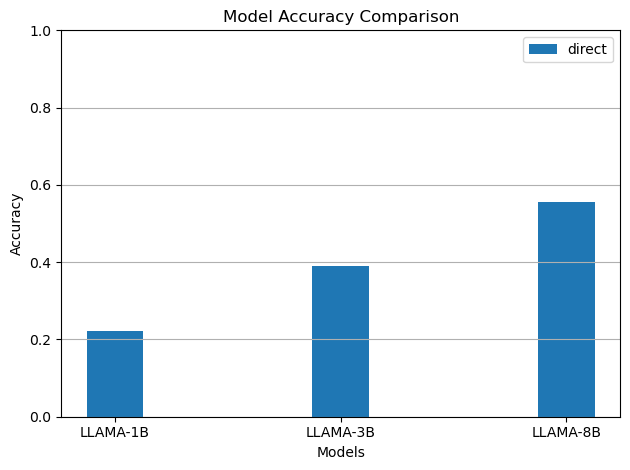

In [ ]:
bar_width = 0.25  
models_condensed = ["LLAMA-1B", "LLAMA-3B", "LLAMA-8B"]
x = np.arange(len(models))  # The label locations

for method_index, method in enumerate(prompting_methods):
    accuracies = [results[model][method_index] for model in models]
    plt.bar(x + method_index * bar_width, accuracies, width=bar_width, label=method)

plt.title('Model Accuracy Comparison')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.xticks(x, models_condensed)  
plt.ylim(0, 1)  
plt.legend()
plt.grid(axis='y')  
plt.tight_layout()
plt.show()